<a href="https://colab.research.google.com/github/misko/spf/blob/main/software/notebooks/90_spf_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'prawnukkah'
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
! git clone https://github.com/misko/spf.git

Cloning into 'spf'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 208 (delta 113), reused 127 (delta 56), pack-reused 0
Receiving objects: 100% (208/208), 13.95 MiB | 11.04 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [ ]:
from smart_open import open
import pickle
session=pickle.load(
    open('gs://spf-data/sessions_sigma0.0_sources3_n8192_timesteps256_timeinterval0.3_dtbounce/session_00000001.pkl','rb'))
from spf.nn.rf_torch import labels_to_source_images,detector_positions_to_theta_grid,radio_to_image
#generate the images for the session
d={}
d['source_image_at_t']=labels_to_source_images(torch.from_numpy(session['source_positions_at_t'])[None],width)[0]
d['detector_theta_image_at_t']=detector_positions_to_theta_grid(session['detector_position_at_t'][None],width)[0]
d['radio_image_at_t']=radio_to_image(session['beam_former_outputs_at_t'][None],d['detector_theta_image_at_t'][None])[0]
d['radio_image_at_t_normed']=d['radio_image_at_t']/d['radio_image_at_t'].sum(axis=2,keepdims=True).sum(axis=3,keepdims=True)

NameError: ignored

In [ ]:
session['width_at_t'].shape

NameError: ignored

In [ ]:

import matplotlib.pyplot as plt 


def plot_trajectory(ax,
                    positions,
                    width,
                    ms=30,
                    steps_per_fade=10,
                    fadep=0.8,
                    c='b',
                    rings=False,
                    label=None):
  ax.set_xlim([0,width])
  ax.set_ylim([0,width])
  n_steps=positions.shape[0]//steps_per_fade
  if positions.shape[0]%steps_per_fade!=0:
    n_steps+=1
  alpha=1.0
  for n in np.arange(n_steps):
    start=positions.shape[0]-(n+1)*steps_per_fade
    end=start+steps_per_fade
    start=max(0,start)
    ax.plot( positions[start:end,0], positions[start:end,1],'--',alpha=alpha,color=c,label=label)
    alpha*=fadep
  
  ax.plot( positions[-1,0], positions[-1,1],'.',ms=ms,c=c)
  if rings:
    n=4
    for x in range(n):
      ax.plot( positions[-1,0], positions[-1,1],'.',ms=ms*(1.8**x),c=c,alpha=1/n)


In [ ]:

from PIL import Image
                

def filenames_to_gif(filenames,output_gif_fn):
        images=[]
        for fn in filenames:
                images.append(Image.open(fn).resize((1200,600)))

        images[0].save(output_gif_fn,
                                         save_all = True, append_images = images[1:],
                                         optimize = False, duration = 50,loop=0)

In [ ]:
!rm 01_basic*.png

width=session['width_at_t'][0][0]

filenames=[]
plt.ioff()
step_size=4
for idx in np.arange(1,256,step_size):
  fig=plt.figure(figsize=(12,12))
  axs=fig.subplots(2,2)
  for _a in [0,1]:
    for _b in [0,1]:
      if _a==0 and _b==1: 
        continue
      axs[_a,_b].set_xlabel("X (m)")
      axs[_a,_b].set_ylabel("Y (m)")

  axs[0,0].set_title("Position map")
  plot_trajectory(axs[0,0],session['detector_position_at_t'][:idx],width,ms=30,label='detector')
  for n in np.arange(session['source_positions_at_t'].shape[1]):
    rings=(session['broadcasting_positions_at_t'][idx,n,0]==1)
    plot_trajectory(axs[0,0],session['source_positions_at_t'][:idx,n],width,ms=15,c='r',rings=rings,label='emitter %d' % n)
  #axs[0,0].legend()
  handles, labels = axs[0,0].get_legend_handles_labels()
  by_label = dict(zip(labels, handles))
  axs[0,0].legend(by_label.values(), by_label.keys())
  #lets draw the radio
  axs[1,0].imshow(d['source_image_at_t'][idx,0].T,origin='lower')
  axs[1,0].set_title("Emitters as image at t=%d" % idx)

  axs[1,1].imshow(d['radio_image_at_t'][idx,0].T,origin='lower')
  axs[1,1].set_title("Radio feature at t=%d" % idx)

  axs[0,1].plot(session['thetas_at_t'][idx],session['beam_former_outputs_at_t'][idx])
  axs[0,1].set_title("Beamformer output at t=%d" % idx)
  fn='01_basic_frame_%04d.png' % idx
  filenames.append(fn)
  fig.savefig(fn)
  plt.close(fig)
plt.ion()

In [ ]:

# importing libraries
import os
import cv2 
from PIL import Image

images=[]
for fn in filenames:
  images.append(Image.open(fn))

images[0].save('01_basic.gif',
               save_all = True, append_images = images[1:], 
               optimize = False, duration = 20)

In [ ]:
!sudo apt-get install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.10.23+dfsg-2.1ubuntu11.7).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
!convert -resize 600x600 -delay 20 -loop 0 01_basic*.png 01_basic_take3.gif

In [9]:
4.6%2.2

0.1999999999999993

<ipython-input-13-0fe6ad67f4eb>:130: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(8,4))


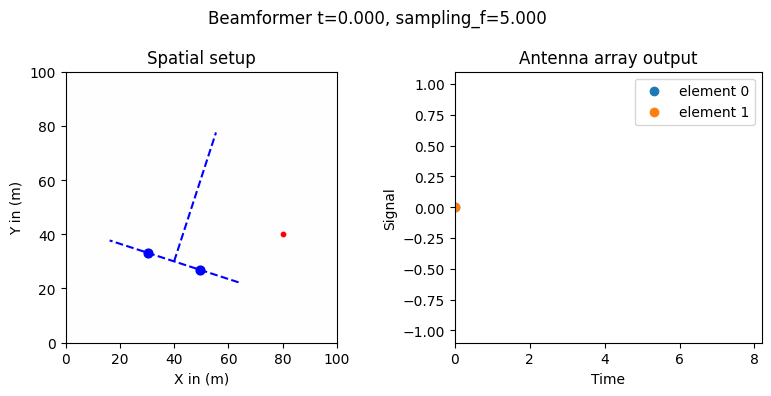

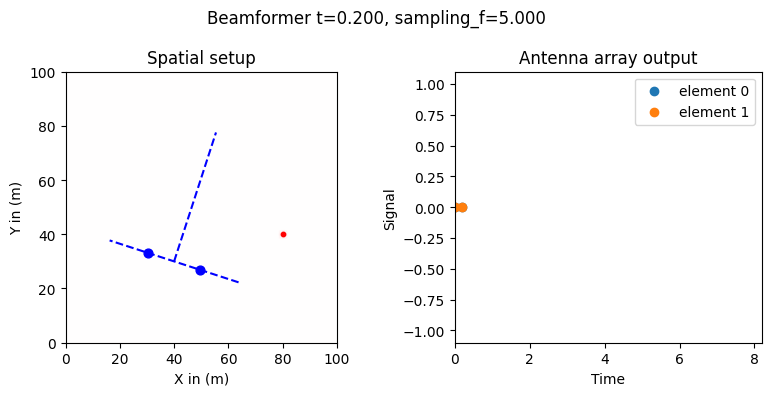

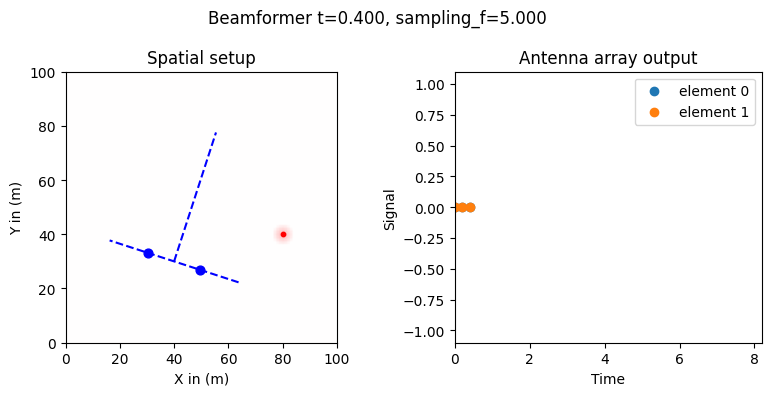

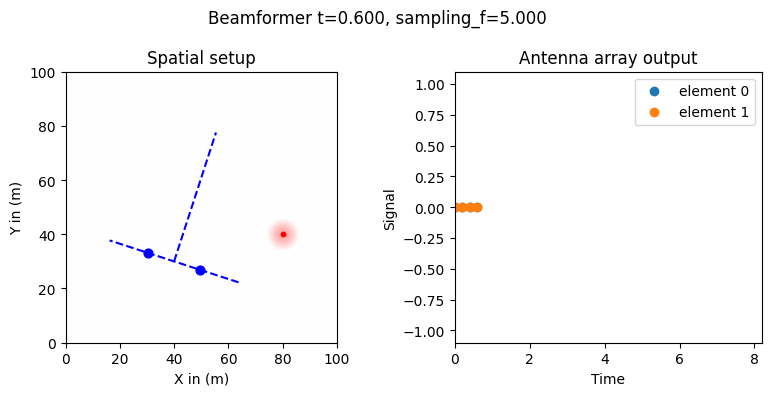

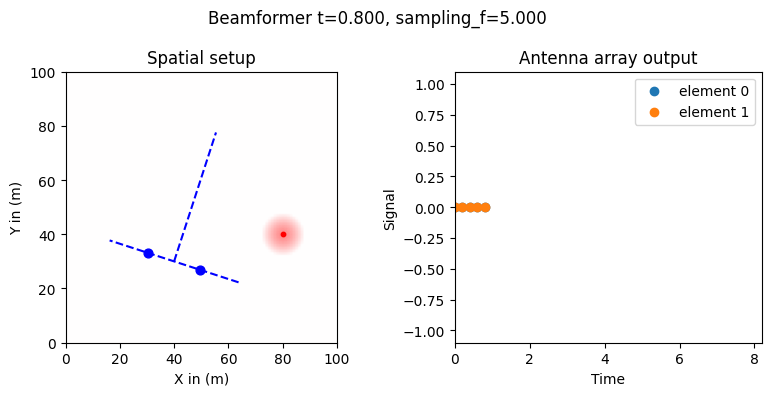

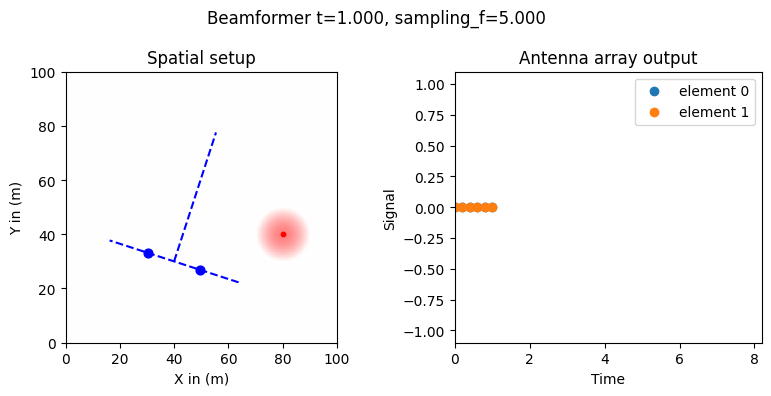

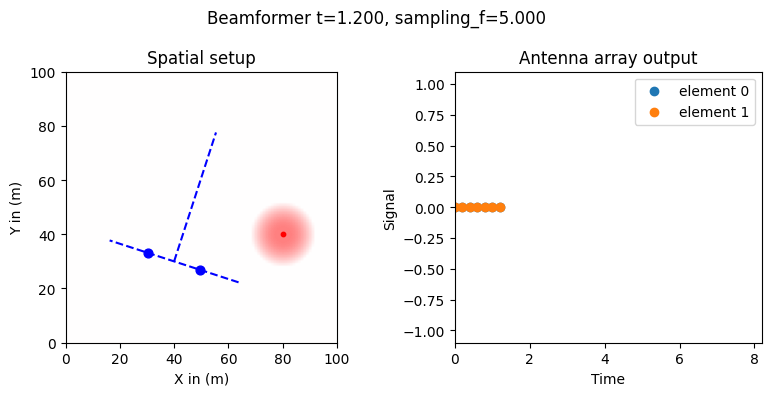

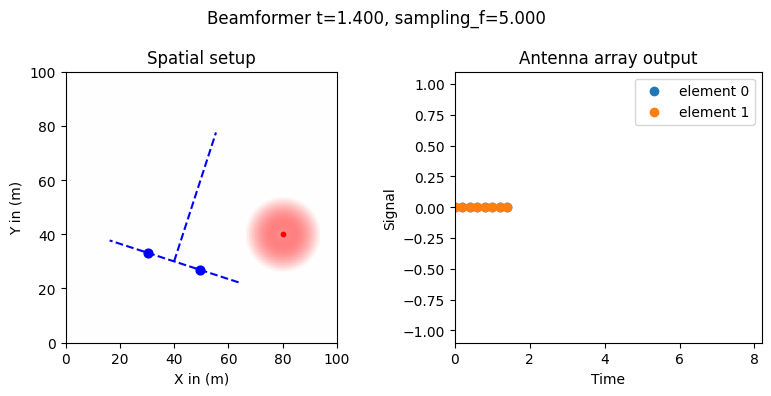

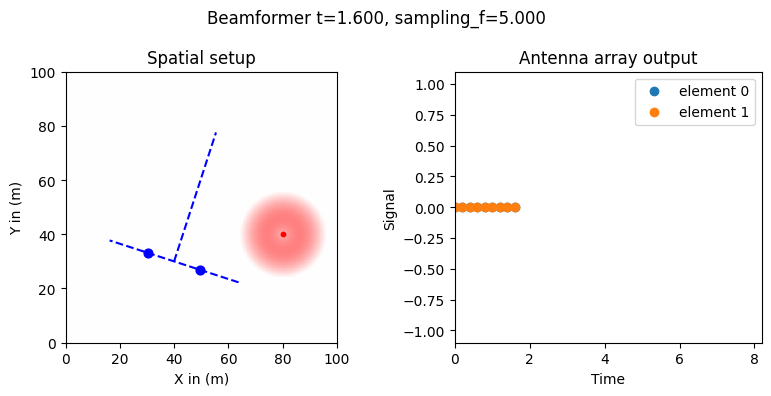

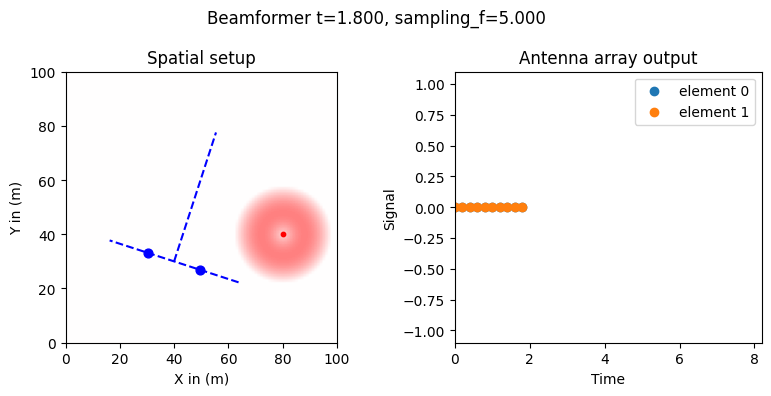

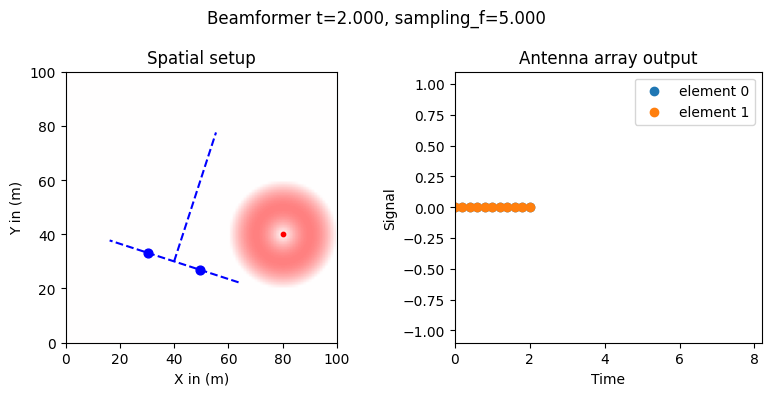

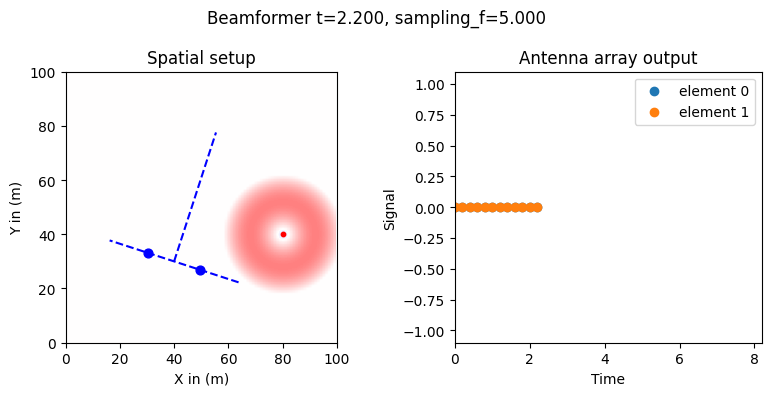

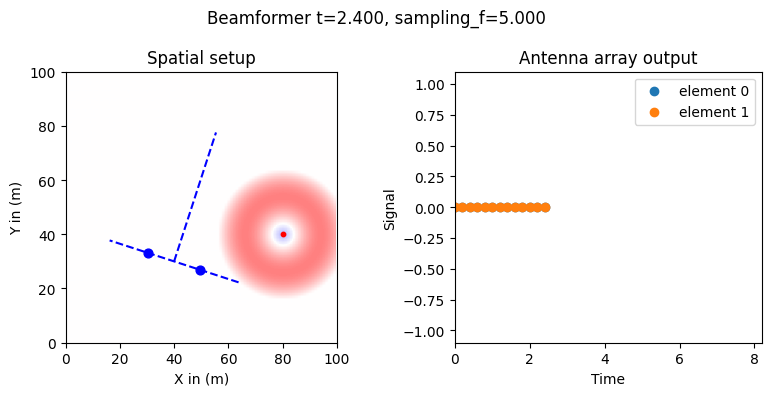

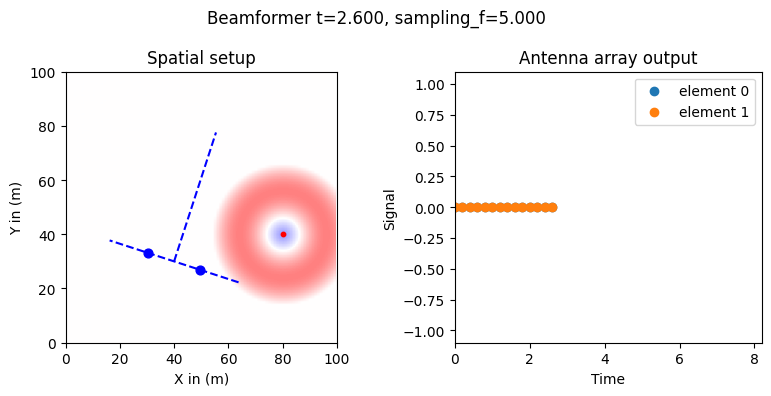

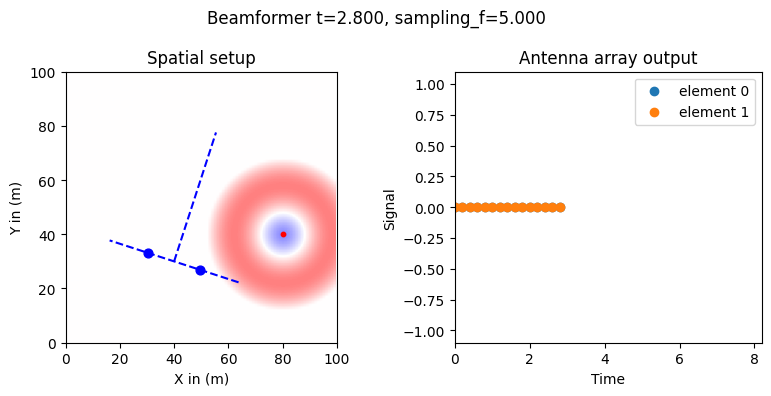

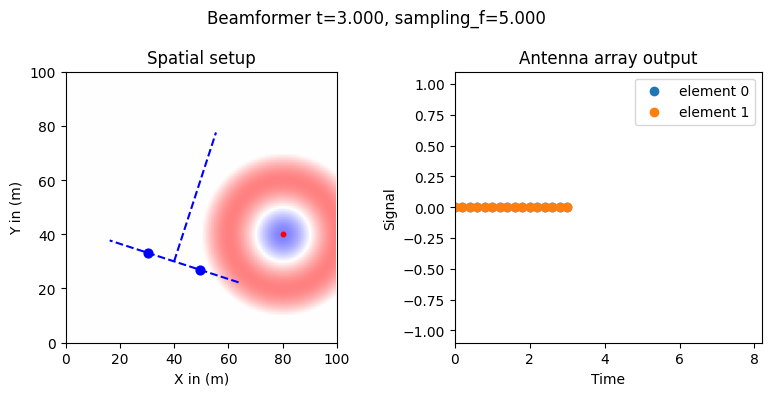

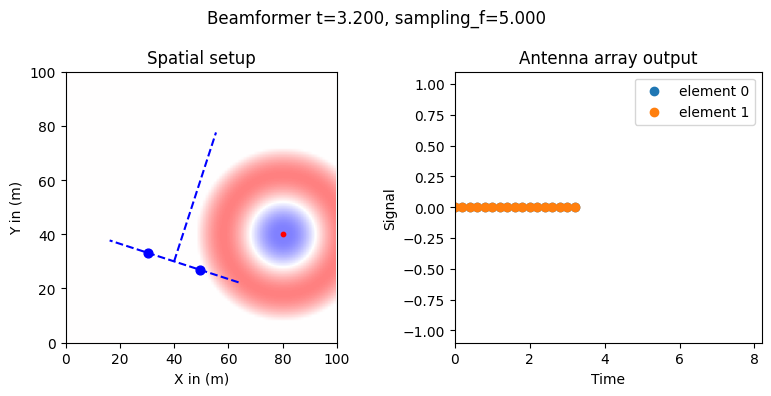

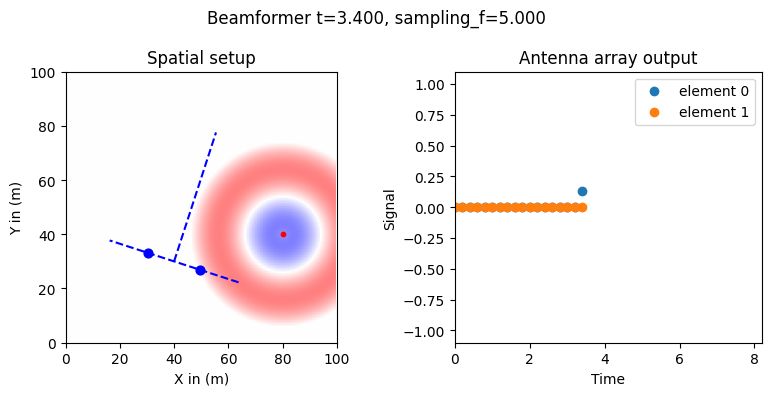

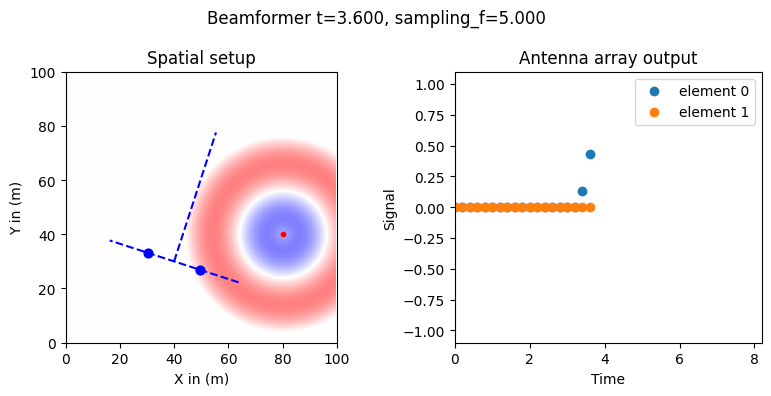

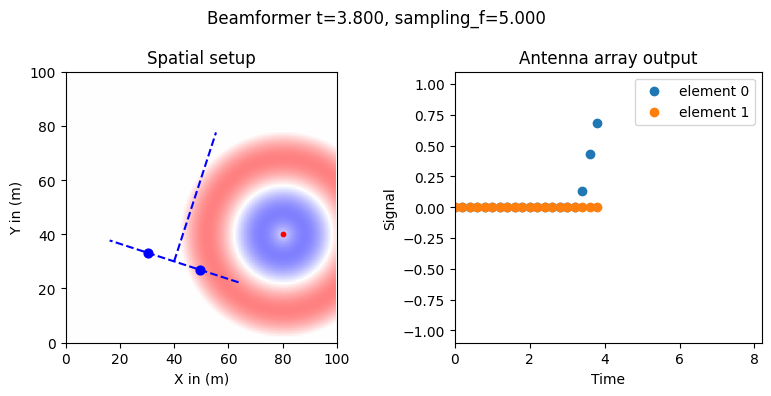

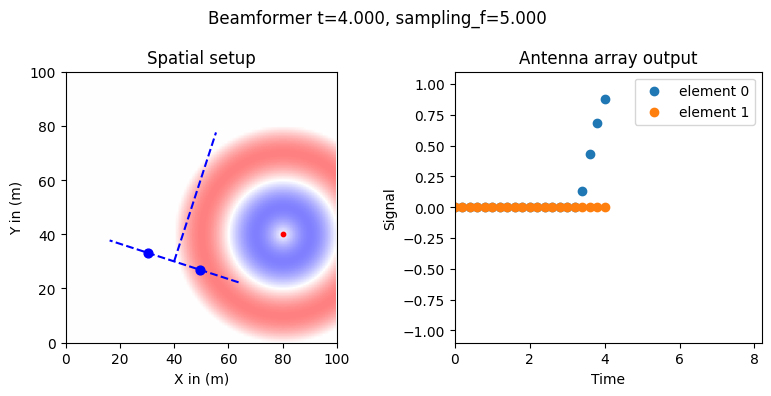

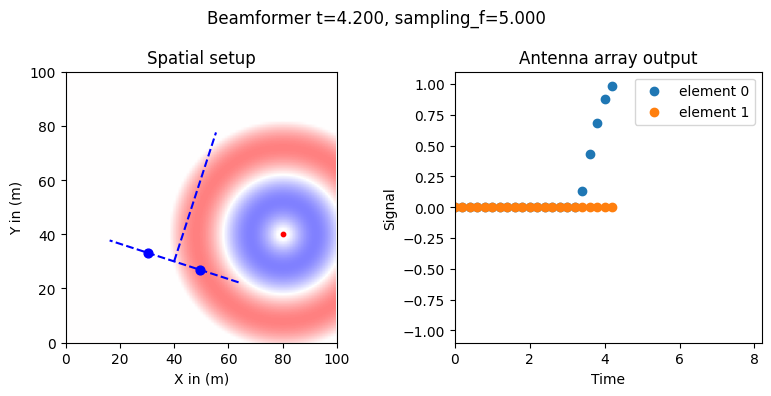

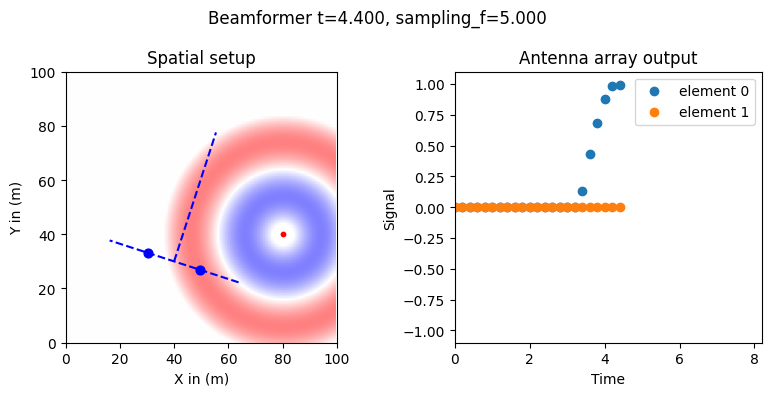

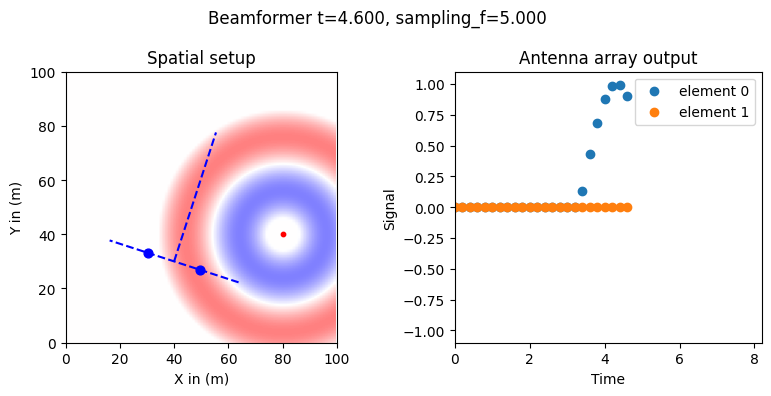

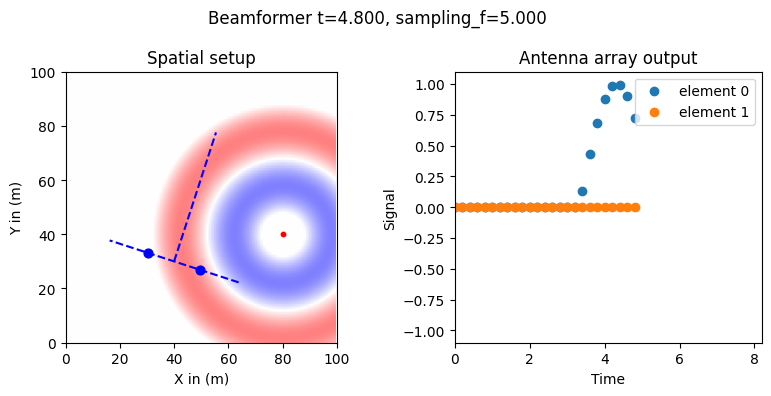

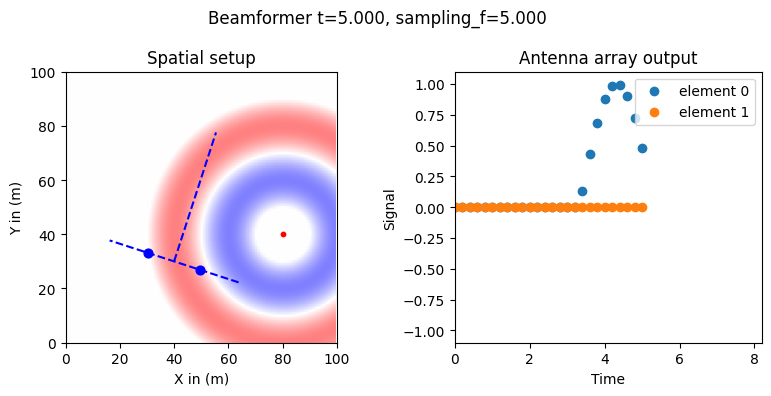

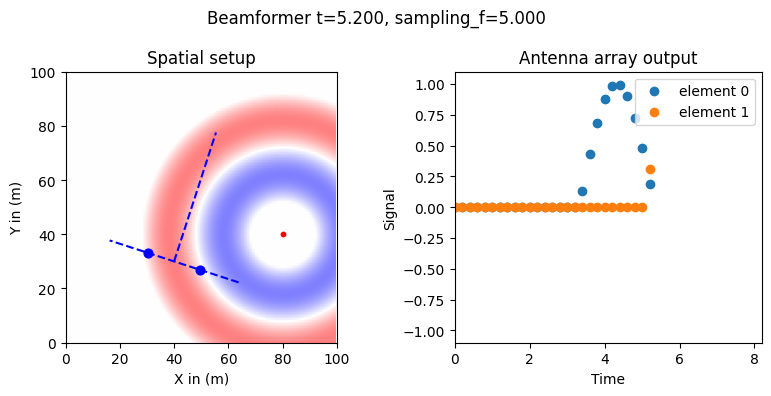

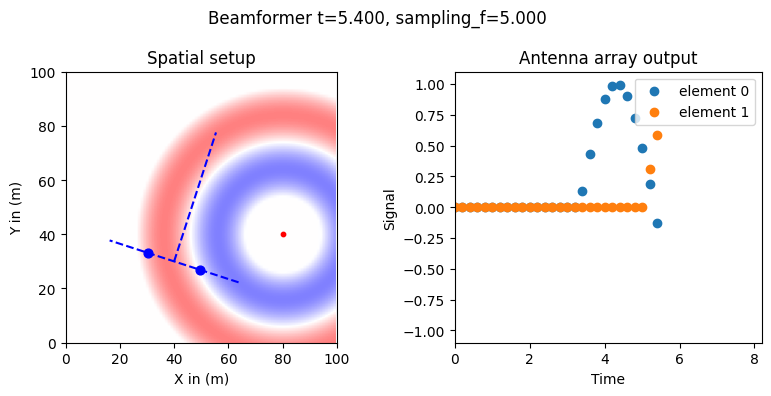

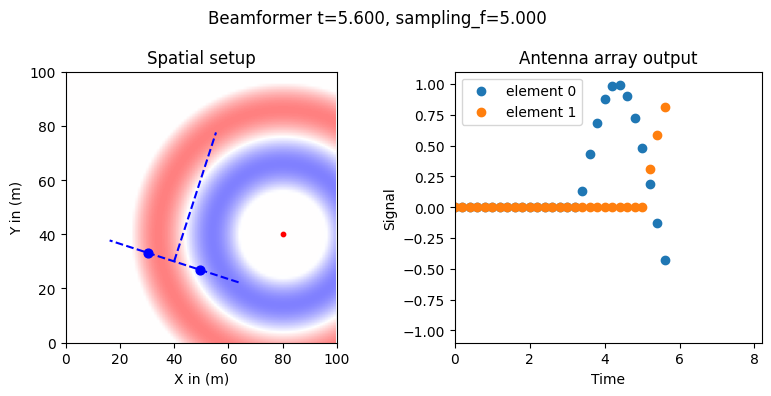

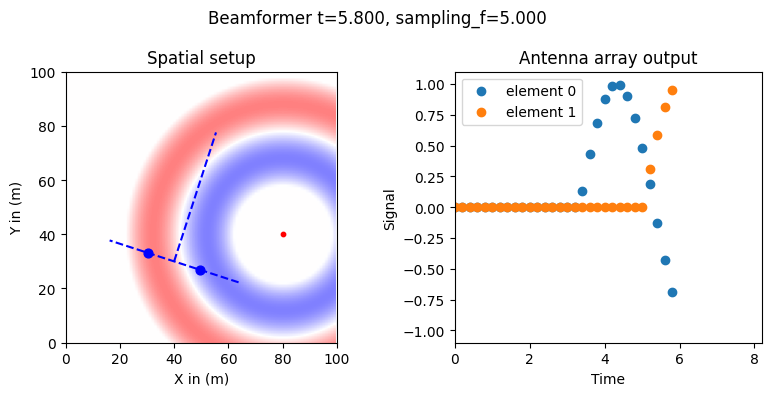

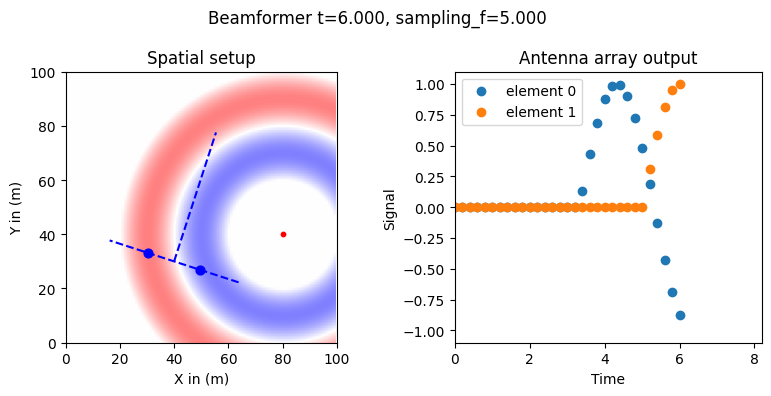

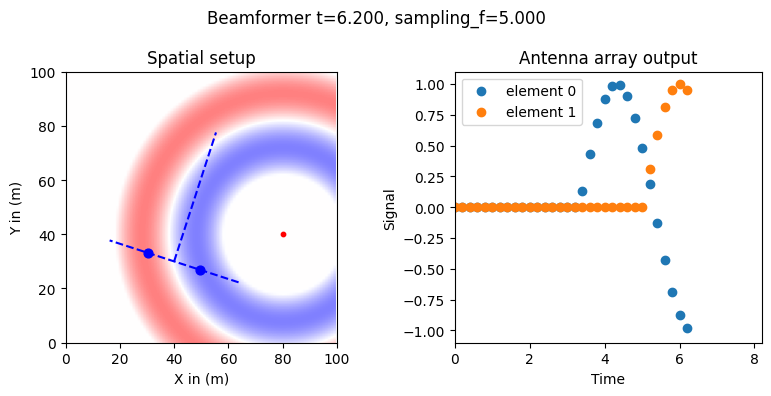

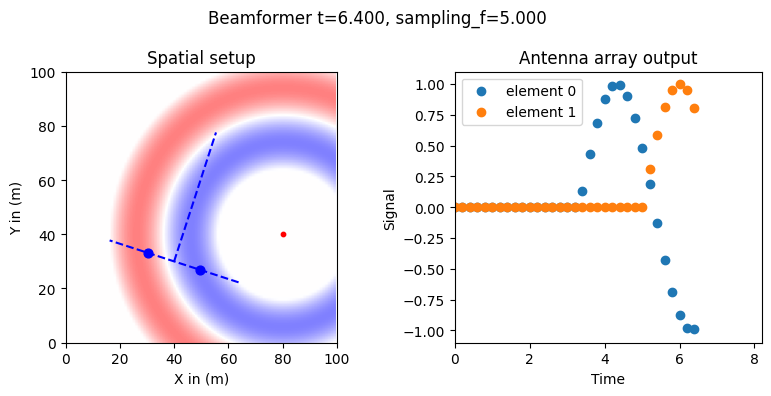

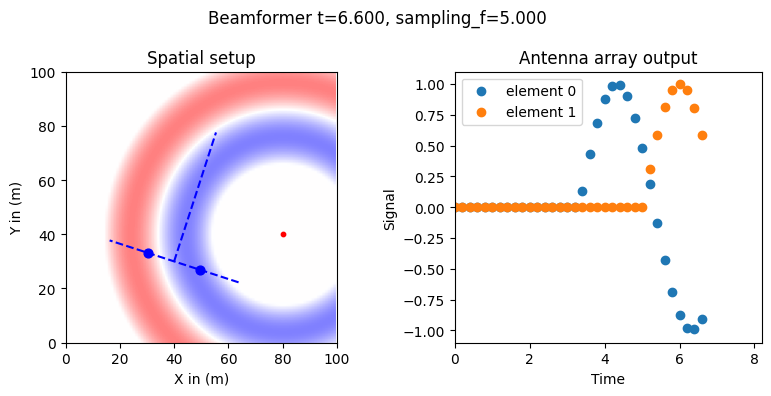

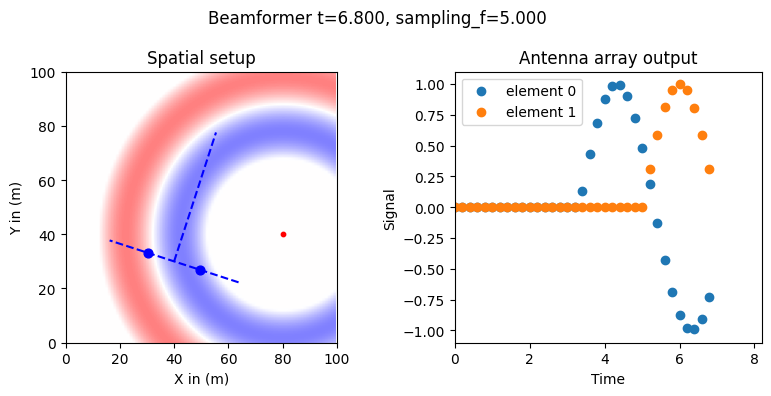

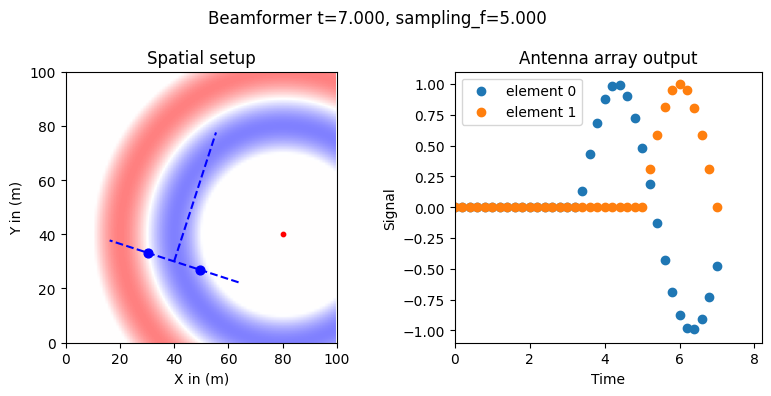

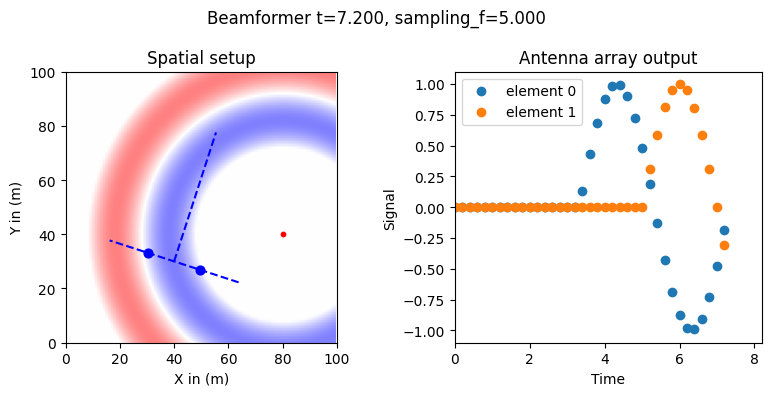

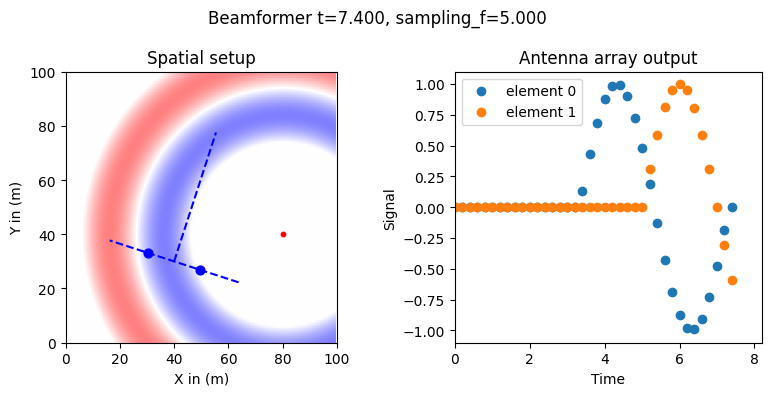

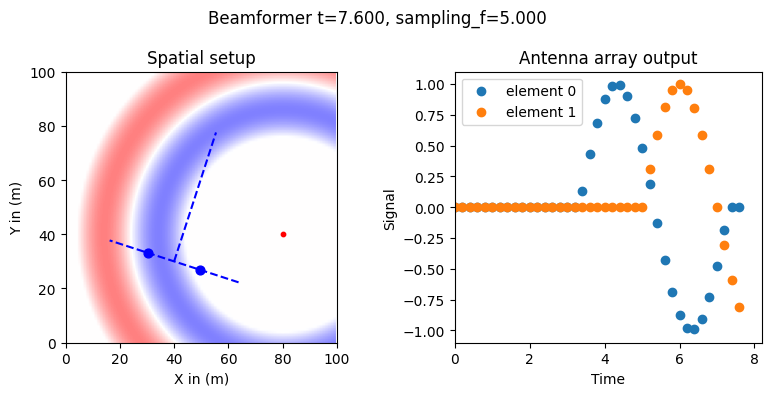

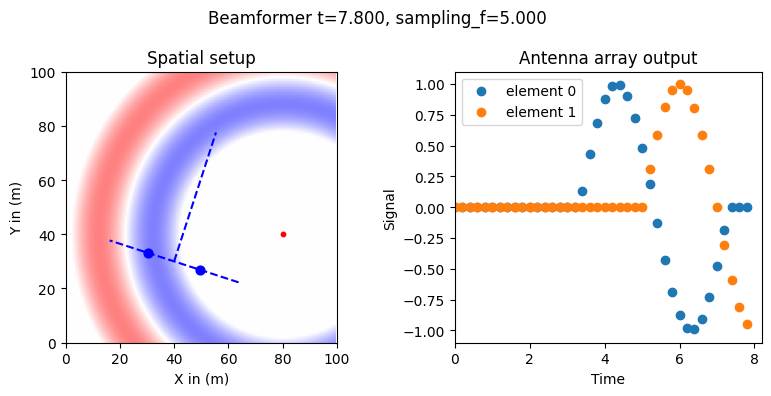

In [13]:
344#lets try to draw some beamforming
import numpy as np
import matplotlib.pyplot as plt

def pairwise_distances(detectors,sources):
  assert(detectors.ndim==2)
  assert(sources.ndim==2)
  return np.linalg.norm(sources[None]-detectors[:,None],axis=-1)

def orthogonal_2d(v):
  return np.array([-v[1],v[0]])


def get_grid(width):
        _xy=np.arange(width).astype(np.int16)
        _x,_y=np.meshgrid(_xy,_xy)
        return np.stack((_x,_y)).transpose(2,1,0)

def signal_at_distances_and_t(scene, dists,t):
  phases=2*np.pi*(scene['f']*t-(dists/scene['wavelength']))
  phases[phases<0]=0
  cycle=(phases//(2*np.pi*scene['emission_cycle_length']))%scene['emission_cycle_pause']
  phases[cycle!=0]=0
  return np.sin(phases)

def draw_sampling(scene,ax):
  ax.set_title('Antenna array output')
  pwd=pairwise_distances(scene['element_positions'],scene['emitter_positions'])
  sampling_n=int(scene['t']*scene['sampling_f'])+1
  if sampling_n==0:
    return
  signal_at_time_detector_source=signal_at_distances_and_t(
      scene,
      pwd[None],
      np.arange(sampling_n)[:,None,None]*(1/scene['sampling_f']))
  n_time,n_detectors,n_sources=signal_at_time_detector_source.shape
  xs=np.arange(n_time)*1/scene['sampling_f']
  for detector_idx in range(n_detectors):
    for source_idx in range(n_sources):
      ax.scatter(xs,signal_at_time_detector_source[:,detector_idx,source_idx],label='element %d' % detector_idx)
  ax.legend()
  ax.set_xlabel("Time")
  ax.set_ylabel("Signal")
  ax.set_ylim([-1.1,1.1])
  ax.set_xlim([0,(scene['time_steps']+1)*scene['time_per_step']])

def draw_scene(scene,ax):
  ax.cla()
  g=get_grid(scene['width'])
  dists=np.linalg.norm(g-emitter_positions[0],axis=2).T
  sig_dists=signal_at_distances_and_t(scene,dists,scene['t'])
  ax.imshow(sig_dists,origin='lower',alpha=0.5,cmap='bwr',vmin=-1, vmax=1)

  #plt.pause(0.1)

  #draw the receiver antenna
  ax.scatter(scene['element_positions'][:,0],
             scene['element_positions'][:,1],s=160,c='b',marker='.')
  #draw the normal to the array
  array_center_normal=scene['array_center']+scene['width']/2*scene['array_normal']
  ax.plot([scene['array_center'][0],array_center_normal[0]],
          [scene['array_center'][1],array_center_normal[1]],linestyle='--',c='b')#+3*array_normal)
  #draw parallel to the array
  a1=scene['array_center']-(scene['width']/4)*orthogonal_2d(scene['array_normal'])
  a2=scene['array_center']+(scene['width']/4)*orthogonal_2d(scene['array_normal'])
  ax.plot([a1[0],a2[0]],
          [a1[1],a2[1]],linestyle='--',c='b')#+3*array_normal)

  ax.scatter(scene['emitter_positions'][:,0],
             scene['emitter_positions'][:,1],s=40,c='r',marker='.')

  ax.set_xlim([0,scene['width']])
  ax.set_ylim([0,scene['width']])
  ax.set_xlabel("X in (m)")
  ax.set_ylabel("Y in (m)")
  ax.set_title("Spatial setup")


width=100
wavelength=40
c=10
f=c/wavelength

#detector
array_center=np.array([40,30])
array_theta=np.pi*0.4
array_normal=np.array([np.cos(array_theta),np.sin(array_theta)])
n_elements=2
element_offset=wavelength/2
offsets=np.arange(n_elements)*element_offset
offsets-=offsets.mean()
element_positions=array_center.reshape(1,2)+np.vstack([ orthogonal_2d(array_normal)*offset for offset in offsets])

#emitter
emitter_positions=np.array([[80,40]])

for sampling_f in [f*20]: #,f*5,f*10,f*1]:
  scene={
      'element_positions':element_positions,
      'width':width,
      'array_center':array_center,
      'array_normal':array_normal,
      'emitter_positions':emitter_positions,
      'sampled_times':[],
      'f':f,
      'wavelength':wavelength,
      'sampling_f':sampling_f,
      't':5,
      'time_steps':40,
      'time_per_step':1/(f*20),
      'emission_cycle_length':1,
      'emission_cycle_pause':3
  }

  filenames=[]
  plt.ion()
  #plt.ioff()
  for t in np.arange(scene['time_steps'])*scene['time_per_step']:
    fig=plt.figure(figsize=(8,4))
    axs=fig.subplots(1,2)
    scene['t']=t
    draw_scene(scene,axs[0])
    draw_sampling(scene,axs[1])
    fn='out_%d.png' % t
    fig.suptitle("Beamformer t=%0.3f, sampling_f=%0.3f" % (t,scene['sampling_f']))
    fig.tight_layout()
    fig.savefig(fn)
    filenames.append(fn)
  #filenames_to_gif(filenames,'beamforming_sf%0.3f_f%0.3f.gif' % (scene['sampling_f'],scene['f']))
  #plt.ion()
